## Import libaries

In [0]:
import pandas as pd
import numpy as np 
import seaborn as sns 
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.metrics import f1_score

## Import data

In [0]:
# Read from url - Take time to run
url = "http://stat-computing.org/dataexpo/2009/2008.csv.bz2"
df = pd.read_csv(url, compression='bz2')

# Read from drive
#df = pd.read_csv('./temp/Airline.csv')

In [0]:
# Reduce rows
df = df.sample(frac=0.25)

In [4]:
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
5508695,2008,10,9,4,1755.0,1745,1907.0,1854,YV,2678,...,5.0,19.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
643476,2008,2,14,4,1400.0,1350,1453.0,1450,WN,3583,...,2.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
923782,2008,2,8,5,857.0,851,1017.0,1002,EV,4639,...,2.0,35.0,0,NaN,0,6.0,0.0,9.0,0.0,0.0
2359746,2008,4,8,2,1804.0,1745,2238.0,2228,CO,1632,...,6.0,21.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1037408,2008,2,26,2,1637.0,1640,1816.0,1835,9E,2999,...,7.0,22.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN


Variable descriptions: http://stat-computing.org/dataexpo/2009/the-data.html

Reference: https://www.kaggle.com/fabiendaniel/predicting-flight-delays-tutorial

## Data pre-processing

In [5]:
df.count()

Year                 1752432
Month                1752432
DayofMonth           1752432
DayOfWeek            1752432
DepTime              1718469
CRSDepTime           1752432
ArrTime              1714661
CRSArrTime           1752432
UniqueCarrier        1752432
FlightNum            1752432
TailNum              1731710
ActualElapsedTime    1713926
CRSElapsedTime       1752235
AirTime              1713926
ArrDelay             1713926
DepDelay             1718469
Origin               1752432
Dest                 1752432
Distance             1752432
TaxiIn               1714661
TaxiOut              1718279
Cancelled            1752432
CancellationCode       34240
Diverted             1752432
CarrierDelay          380919
WeatherDelay          380919
NASDelay              380919
SecurityDelay         380919
LateAircraftDelay     380919
dtype: int64

In [6]:
#Create Date column
#df['Date'] = pd.to_datetime(df[['Year', 'Month', 'DayofMonth']])

# Drop columns
# Year: The dataset only contains data in 2008
# Cancelled + CancellationCode + Diverted: Cancelled flight does not have delay label.
df.drop(['Year', 'Cancelled', 'CancellationCode', 'Diverted'], axis=1, inplace=True)
# Delay details: Only 20% rows have these features.
df.drop(['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'], axis=1, inplace=True)
# Time: Only keep CRSArrTime, CRSElapsedTime
df.drop(['DepTime', 'ArrTime', 'CRSDepTime', 'ActualElapsedTime', 'DepDelay'], axis=1, inplace=True)
# Airport: Only keep the Dest Airport
df.drop(['Origin'], axis=1, inplace=True)
# Carrier: Drop FlightNum and TailNum
df.drop(['FlightNum', 'TailNum'], axis=1, inplace=True)

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

df.count()

Month             1713926
DayofMonth        1713926
DayOfWeek         1713926
CRSArrTime        1713926
UniqueCarrier     1713926
CRSElapsedTime    1713926
AirTime           1713926
ArrDelay          1713926
Dest              1713926
Distance          1713926
TaxiIn            1713926
TaxiOut           1713926
dtype: int64

In [0]:
# Convert CRSArrTime to Parts of the Day
conditions = [
    (df['CRSArrTime'] >= 500) & (df['CRSArrTime'] < 1201),
    (df['CRSArrTime'] >= 1201) & (df['CRSArrTime'] < 1701),
    (df['CRSArrTime'] >= 1701) & (df['CRSArrTime'] < 2101)]
choices = [1, 2, 3]
df['PotD'] = np.select(conditions, choices, default=4)

# Morning, Afternoon, Evening, Night

In [0]:
# Convert ArrDelay to Delay
# A flight only counts as late if it is more than 30 minutes late.
conditions = [
    (df['ArrDelay'] > 30)]
choices = [1]
df['Delay'] = np.select(conditions, choices, default=0)
df.drop(['CRSArrTime'], axis=1, inplace=True)

In [9]:
df.dtypes

Month               int64
DayofMonth          int64
DayOfWeek           int64
UniqueCarrier      object
CRSElapsedTime    float64
AirTime           float64
ArrDelay          float64
Dest               object
Distance            int64
TaxiIn            float64
TaxiOut           float64
PotD                int64
Delay               int64
dtype: object

In [10]:
df.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,CRSElapsedTime,AirTime,ArrDelay,Dest,Distance,TaxiIn,TaxiOut,PotD,Delay
5508695,10,9,4,YV,69.0,48.0,13.0,ORF,290,5.0,19.0,3,0
643476,2,14,4,WN,60.0,44.0,3.0,MSY,303,2.0,7.0,2,0
923782,2,8,5,EV,131.0,103.0,15.0,TUL,674,2.0,35.0,1,0
2359746,4,8,2,CO,223.0,187.0,10.0,LGA,1416,6.0,21.0,4,0
1037408,2,26,2,9E,175.0,130.0,-19.0,DSM,897,7.0,22.0,3,0


## Data analysis

In [11]:
#Check basic stats
df.describe()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,Distance,TaxiIn,TaxiOut,PotD,Delay
count,1.713926e+06,1.713926e+06,1.713926e+06,1.713926e+06,1.713926e+06,1.713926e+06,1.713926e+06,1.713926e+06,1.713926e+06,1.713926e+06,1.713926e+06
mean,6.389406e+00,1.572876e+01,3.926202e+00,1.291473e+02,1.040770e+02,8.141693e+00,7.293590e+02,6.861068e+00,1.645214e+01,2.244526e+00,1.313015e-01
std,3.396570e+00,8.793587e+00,1.988241e+00,6.963255e+01,6.753656e+01,3.835040e+01,5.641675e+02,4.925750e+00,1.134787e+01,1.019131e+00,3.377299e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-1.090000e+02,1.100000e+01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,3.000000e+00,8.000000e+00,2.000000e+00,8.000000e+01,5.500000e+01,-1.000000e+01,3.260000e+02,4.000000e+00,1.000000e+01,1.000000e+00,0.000000e+00
50%,6.000000e+00,1.600000e+01,4.000000e+00,1.110000e+02,8.600000e+01,-2.000000e+00,5.810000e+02,6.000000e+00,1.400000e+01,2.000000e+00,0.000000e+00
75%,9.000000e+00,2.300000e+01,6.000000e+00,1.590000e+02,1.320000e+02,1.200000e+01,9.540000e+02,8.000000e+00,1.900000e+01,3.000000e+00,0.000000e+00
max,1.200000e+01,3.100000e+01,7.000000e+00,6.600000e+02,9.810000e+02,2.453000e+03,4.962000e+03,2.400000e+02,4.290000e+02,4.000000e+00,1.000000e+00


In [12]:
#Check correlation
df.corr()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,Distance,TaxiIn,TaxiOut,PotD,Delay
Month,1.000000,-0.000712,-0.005879,-0.006836,-0.012909,-0.042138,-0.006187,0.006654,-0.016631,-0.005561,-0.034473
DayofMonth,-0.000712,1.000000,0.005286,0.000583,-0.000026,0.001594,0.000387,-0.001912,-0.000389,-0.000925,0.000260
DayOfWeek,-0.005879,0.005286,1.000000,0.015021,0.013864,0.010790,0.016739,0.009228,-0.007051,0.003628,0.010407
CRSElapsedTime,-0.006836,0.000583,0.015021,1.000000,0.988253,0.012195,0.983219,0.104068,0.142784,0.090870,0.030955
AirTime,-0.012909,-0.000026,0.013864,0.988253,1.000000,0.034101,0.982988,0.084840,0.107842,0.077841,0.040653
ArrDelay,-0.042138,0.001594,0.010790,0.012195,0.034101,1.000000,0.006159,0.122179,0.324040,0.115719,0.741165
Distance,-0.006187,0.000387,0.016739,0.983219,0.982988,0.006159,1.000000,0.076926,0.090991,0.090672,0.018629
TaxiIn,0.006654,-0.001912,0.009228,0.104068,0.084840,0.122179,0.076926,1.000000,0.040711,-0.019308,0.088357
TaxiOut,-0.016631,-0.000389,-0.007051,0.142784,0.107842,0.324040,0.090991,0.040711,1.000000,0.057664,0.290544
PotD,-0.005561,-0.000925,0.003628,0.090870,0.077841,0.115719,0.090672,-0.019308,0.057664,1.000000,0.134037


In [13]:
# Groupby carrier
df.groupby(['UniqueCarrier']).mean()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,Distance,TaxiIn,TaxiOut,PotD,Delay
UniqueCarrier,,,,,,,,,,,
9E,6.515782,15.783113,3.920400,100.441735,71.195207,3.838438,451.863183,8.492586,18.092411,2.192595,0.104549
AA,6.447223,15.759245,3.953103,167.703996,141.975870,12.470819,1058.092548,8.248107,16.833502,2.325719,0.171009
AQ,1.492828,15.590676,3.990266,74.607582,61.280738,-2.663422,420.937500,3.883709,7.991291,2.141906,0.022029
AS,6.388023,15.608942,3.931960,154.946593,131.704132,5.226338,960.146024,5.790272,15.534318,2.349004,0.109253
B6,6.428138,15.870224,4.001652,179.736434,150.168399,10.888062,1099.129692,6.243763,21.805190,2.350515,0.168754
CO,6.332111,15.776374,3.904690,186.543730,155.930687,11.024856,1155.727843,7.970295,20.469745,2.306358,0.152072
DL,6.505341,15.699467,3.916134,156.257526,126.871843,7.911193,924.596870,8.692289,20.584840,2.246943,0.117708
EV,6.510763,15.636729,3.923329,95.822702,70.015442,10.097032,444.982404,7.358861,16.732218,2.098633,0.147477
F9,6.451369,15.651889,3.935327,143.338842,121.614772,6.028897,879.163822,7.400579,14.547834,2.339303,0.091138


In [14]:
# Groupby destination airport
df.groupby(['Dest']).mean()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,Distance,TaxiIn,TaxiOut,PotD,Delay
Dest,,,,,,,,,,,
ABE,6.716667,15.717544,3.835965,100.437719,73.854386,8.450000,537.621053,4.587719,19.927193,2.769298,0.136842
ABI,6.568598,15.660061,3.940549,53.172256,33.263720,10.085366,158.000000,3.574695,15.167683,2.647866,0.143293
ABQ,6.396243,15.724073,3.944241,114.016807,92.058824,6.193475,651.749679,5.327533,13.572219,2.273060,0.110035
ABY,6.143939,15.215909,3.848485,54.409091,27.973485,12.511364,146.000000,3.534091,24.219697,2.443182,0.170455
ACK,7.294643,16.491071,4.214286,86.794643,44.883929,21.214286,207.535714,5.991071,37.348214,2.107143,0.321429
ACT,5.967146,15.689938,3.749487,45.096509,23.724846,5.817248,89.000000,4.983573,15.026694,2.164271,0.102669
ACV,6.643357,15.326340,3.904429,77.312354,57.625874,13.386946,268.745921,4.571096,16.427739,2.452214,0.172494
ACY,2.466667,14.866667,3.033333,114.500000,88.433333,17.333333,678.000000,3.133333,20.733333,2.933333,0.133333
ADK,6.176471,13.411765,5.941176,186.823529,171.294118,10.058824,1192.000000,4.235294,12.588235,2.705882,0.176471


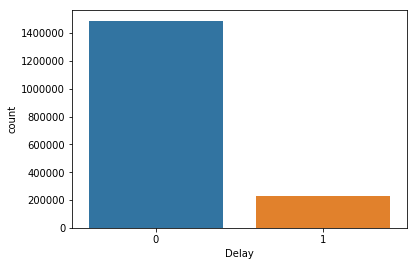

In [15]:
# Bias check
sns.countplot(x="Delay", data=df)

In [0]:
# Check Correlation
def cramers_corrected_stat(x, y):

    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    result=-1
    if len(x.value_counts())==1 :
        print("First variable is constant")
    elif len(y.value_counts())==1:
        print("Second variable is constant")
    else:   
        conf_matrix=pd.crosstab(x, y)

        if conf_matrix.shape[0]==2:
            correct=False
        else:
            correct=True

        chi2 = ss.chi2_contingency(conf_matrix, correction=correct)[0]

        n = sum(conf_matrix.sum())
        phi2 = chi2/n
        r,k = conf_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        result=np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
    return round(result,6)

#### Month

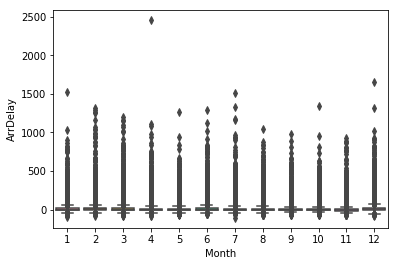

In [17]:
sns.boxplot(x='Month', y='ArrDelay', data=df) #x is feature, y is target

In [18]:
cramers_corrected_stat(df['Delay'], df['Month'])

0.119007

#### DayofMonth

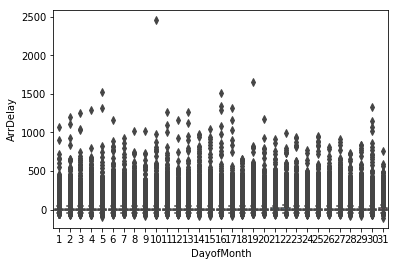

In [19]:
sns.boxplot(x='DayofMonth', y='ArrDelay', data=df) #x is feature, y is target

In [20]:
cramers_corrected_stat(df['Delay'], df['DayofMonth'])

0.037424

#### Weekend

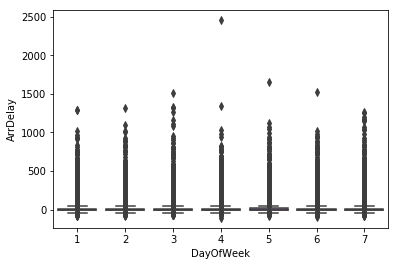

In [21]:
sns.boxplot(x='DayOfWeek', y='ArrDelay', data=df) #x is feature, y is target

In [22]:
cramers_corrected_stat(df['Delay'], df['DayOfWeek'])

0.03555

#### Parts of the Day

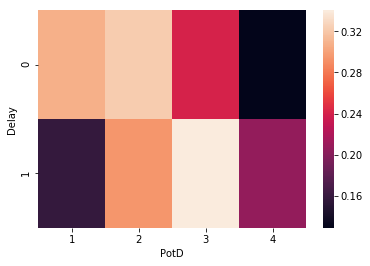

In [23]:
sns.heatmap(pd.crosstab(df['Delay'], df['PotD'], normalize='index'))

In [24]:
cramers_corrected_stat(df['Delay'], df['PotD'])

0.136072

## Model evaluation
We will use F1 score as the evaluation metric. Our target value is binary so it’s a binary classification problem, and out data is inbalance, so in this case F1 score is a good way for evaluation for this type of problems.

In [0]:
# Create a copy of original dataset
df_backup = df.copy()

### Logistic Regression

In [0]:
df = df_backup.copy()

One-hot encoding

In [0]:
# Dest column
df = pd.concat([df, pd.get_dummies(df['Dest'], prefix='Dest',dummy_na=True)],axis=1).drop(['Dest'],axis=1)

# UniqueCarrier column
df = pd.concat([df, pd.get_dummies(df['UniqueCarrier'], prefix='UniqueCarrier',dummy_na=True)],axis=1).drop(['UniqueCarrier'],axis=1)

Holdout

In [0]:
X_data = df.drop(['Delay', 'ArrDelay'], axis=1)
y_data = df['Delay']

# Holdout
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0)

Default parameters

In [0]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

Hyperparameter tuning

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

grid = {'C' : [1, 5, 10]}

model_cv = GridSearchCV(estimator = LogisticRegression(), 
                        param_grid = grid, cv = 3, scoring = 'f1', n_jobs = -1)

model_cv.fit(X_data, y_data)

print("tuned hpyerparameters :(best parameters) ",model_cv.best_params_)
print("accuracy :",model_cv.best_score_)

Tune hyper parameters using 3-values-method, with f1 metric.

### Naive Bayes

In [0]:
df = df_backup.copy()

Label encoder

In [0]:
from sklearn.preprocessing import LabelEncoder

# Dest column
df['Dest'] = LabelEncoder().fit_transform(df['Dest'])

# UniqueCarrier column
df['UniqueCarrier'] = LabelEncoder().fit_transform(df['UniqueCarrier'])

Holdout

In [0]:
X_data = df.drop(['Delay', 'ArrDelay'], axis=1)
y_data = df['Delay']

# Holdout
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0)

In [40]:
X_train.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,CRSElapsedTime,AirTime,Dest,Distance,TaxiIn,TaxiOut,PotD
3691028,7,28,1,17,85.0,66.0,29,460,3.0,14.0,3
3223839,6,24,2,15,303.0,288.0,48,2329,4.0,12.0,1
6406840,11,18,2,3,61.0,46.0,299,199,6.0,16.0,1
6940582,12,10,3,1,155.0,107.0,81,802,31.0,12.0,2
1989833,4,9,3,14,45.0,21.0,193,78,4.0,19.0,1


Default parameters

In [29]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92    298013
           1       0.43      0.23      0.30     44773

   micro avg       0.86      0.86      0.86    342786
   macro avg       0.66      0.59      0.61    342786
weighted avg       0.83      0.86      0.84    342786



### Random Forest
https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

Default parameters

In [30]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_jobs = -1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Report
from sklearn.metrics import classification_report


print(classification_report(y_test, y_pred))

/home/npqbuu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.89      0.99      0.94    298013
           1       0.69      0.19      0.30     44773

   micro avg       0.88      0.88      0.88    342786
   macro avg       0.79      0.59      0.62    342786
weighted avg       0.86      0.88      0.85    342786



Hyperparameter tuning

1  done!
3  done!
5  done!
7  done!
9  done!
11  done!
13  done!
15  done!
20  done!
25  done!


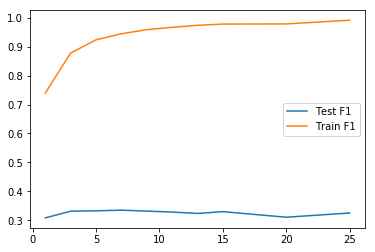

In [48]:
# n_estimators
n_estimators = [1, 3, 5, 7, 9, 11, 13, 15, 20, 25]
test_results = []
train_results = []
for estimator in n_estimators:
    model = RandomForestClassifier(n_estimators = estimator, n_jobs = -1)
    model.fit(X_train, y_train)
  
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    test_results.append(f1)
    
    train_pred = model.predict(X_train)
    f1 = f1_score(y_train, train_pred)
    train_results.append(f1)

    
    print(estimator, ' done!')
    
# Plot metrics line chart
sns.lineplot(x = n_estimators, y = test_results, label='Test F1')
sns.lineplot(x = n_estimators, y = train_results, label='Train F1')

/home/npqbuu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


5.0  done!


/home/npqbuu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


8.0  done!


/home/npqbuu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


11.0  done!


/home/npqbuu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


14.0  done!


/home/npqbuu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


17.0  done!


/home/npqbuu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


20.0  done!


/home/npqbuu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


23.0  done!


/home/npqbuu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


26.0  done!


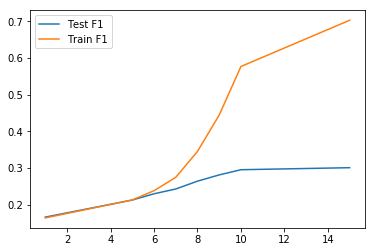

In [47]:
# max_depths
max_depths = np.linspace(5, 26, 8)
test_results = []
train_results = []

for max_depth in max_depths:
    model = RandomForestClassifier(max_depth = max_depth, n_jobs = -1)
    model.fit(X_train, y_train)
  
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    test_results.append(f1)
    
    train_pred = model.predict(X_train)
    f1 = f1_score(y_train, train_pred)
    train_results.append(f1)
    
    print(max_depth, ' done!')

# Plot metrics line chart
sns.lineplot(x = n_estimators, y = test_results, label='Test F1')
sns.lineplot(x = n_estimators, y = train_results, label='Train F1')

**Final model**

Best parameters:
- n_estimators = 5
- max_depths = 10

In [49]:
model = RandomForestClassifier(n_estimators = 5, max_depth = 25, n_jobs = -1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93    298013
           1       0.62      0.21      0.31     44773

   micro avg       0.88      0.88      0.88    342786
   macro avg       0.75      0.59      0.62    342786
weighted avg       0.86      0.88      0.85    342786



# TODO

1. Edit threshhold / class weight
2. PCA: Dimension reducing
3. RFE: Features selection
4. GridsearchCV for tuning
- Tuning with 3 values
- Goal: Precison ~ Recall (F1 score)
5. Compare performances among models